In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from global_land_mask import globe
import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300

In [20]:
h = '/media/rakshith/Seagate Expansion Drive/mraks/TGMS ERA 1959-2021, India only.nc'
ds = xr.open_dataset(h)

In [21]:
lon_grid, lat_grid = np.meshgrid(ds.longitude, ds.latitude)
mask = globe.is_land(lat_grid, lon_grid)

In [22]:
jjas = ds.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds.sel(time=jjas)
clim3 = clim.where(mask>0).mean(dim=['latitude', 'longitude'])

In [66]:
June = clim3.time.dt.month.isin(6)
July = clim3.time.dt.month.isin(7)
August = clim3.time.dt.month.isin(8)
September = clim3.time.dt.month.isin(9)

In [24]:
Qnet = clim3.mtnswrf + clim3.mtnlwrf
P = 86400*(clim3.mtpr)
E = -86400*(clim3.mer)
Pwat = clim3.tcwv
PE = 86400*(clim3.mtpr+clim3.mer)

Text(0.5, 1.0, 'ERA5, Indian land region')

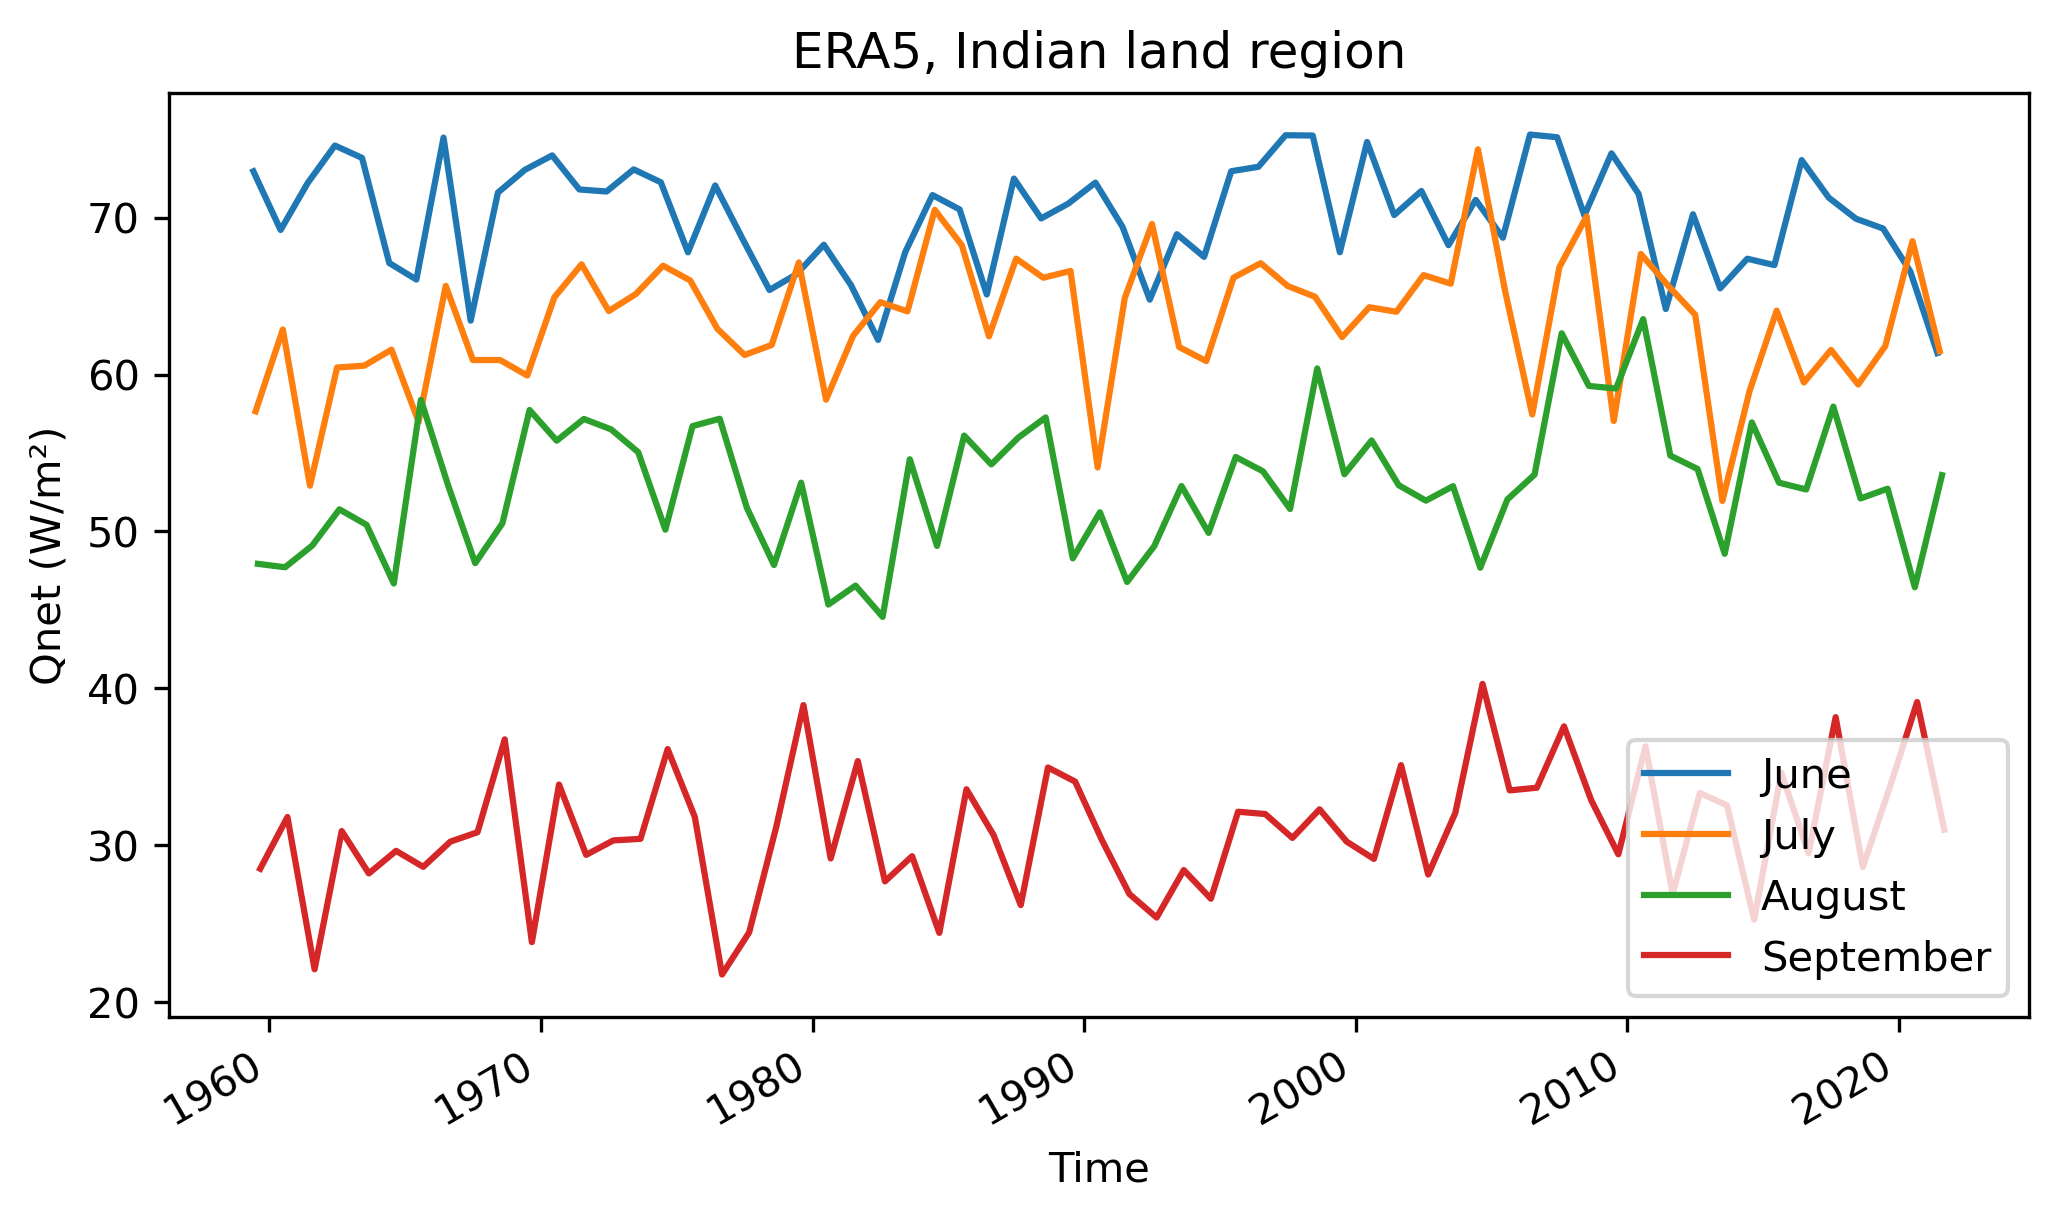

In [7]:
plt.rcParams['figure.figsize'] = [8,4]
Qnet.sel(time=June).plot(label='June')
Qnet.sel(time=July).plot(label='July')
Qnet.sel(time=August).plot(label='August')
Qnet.sel(time=September).plot(label='September')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Qnet (W/m\u00b2)')
plt.title('ERA5, Indian land region')

Text(0.5, 1.0, 'ERA5, Indian land region')

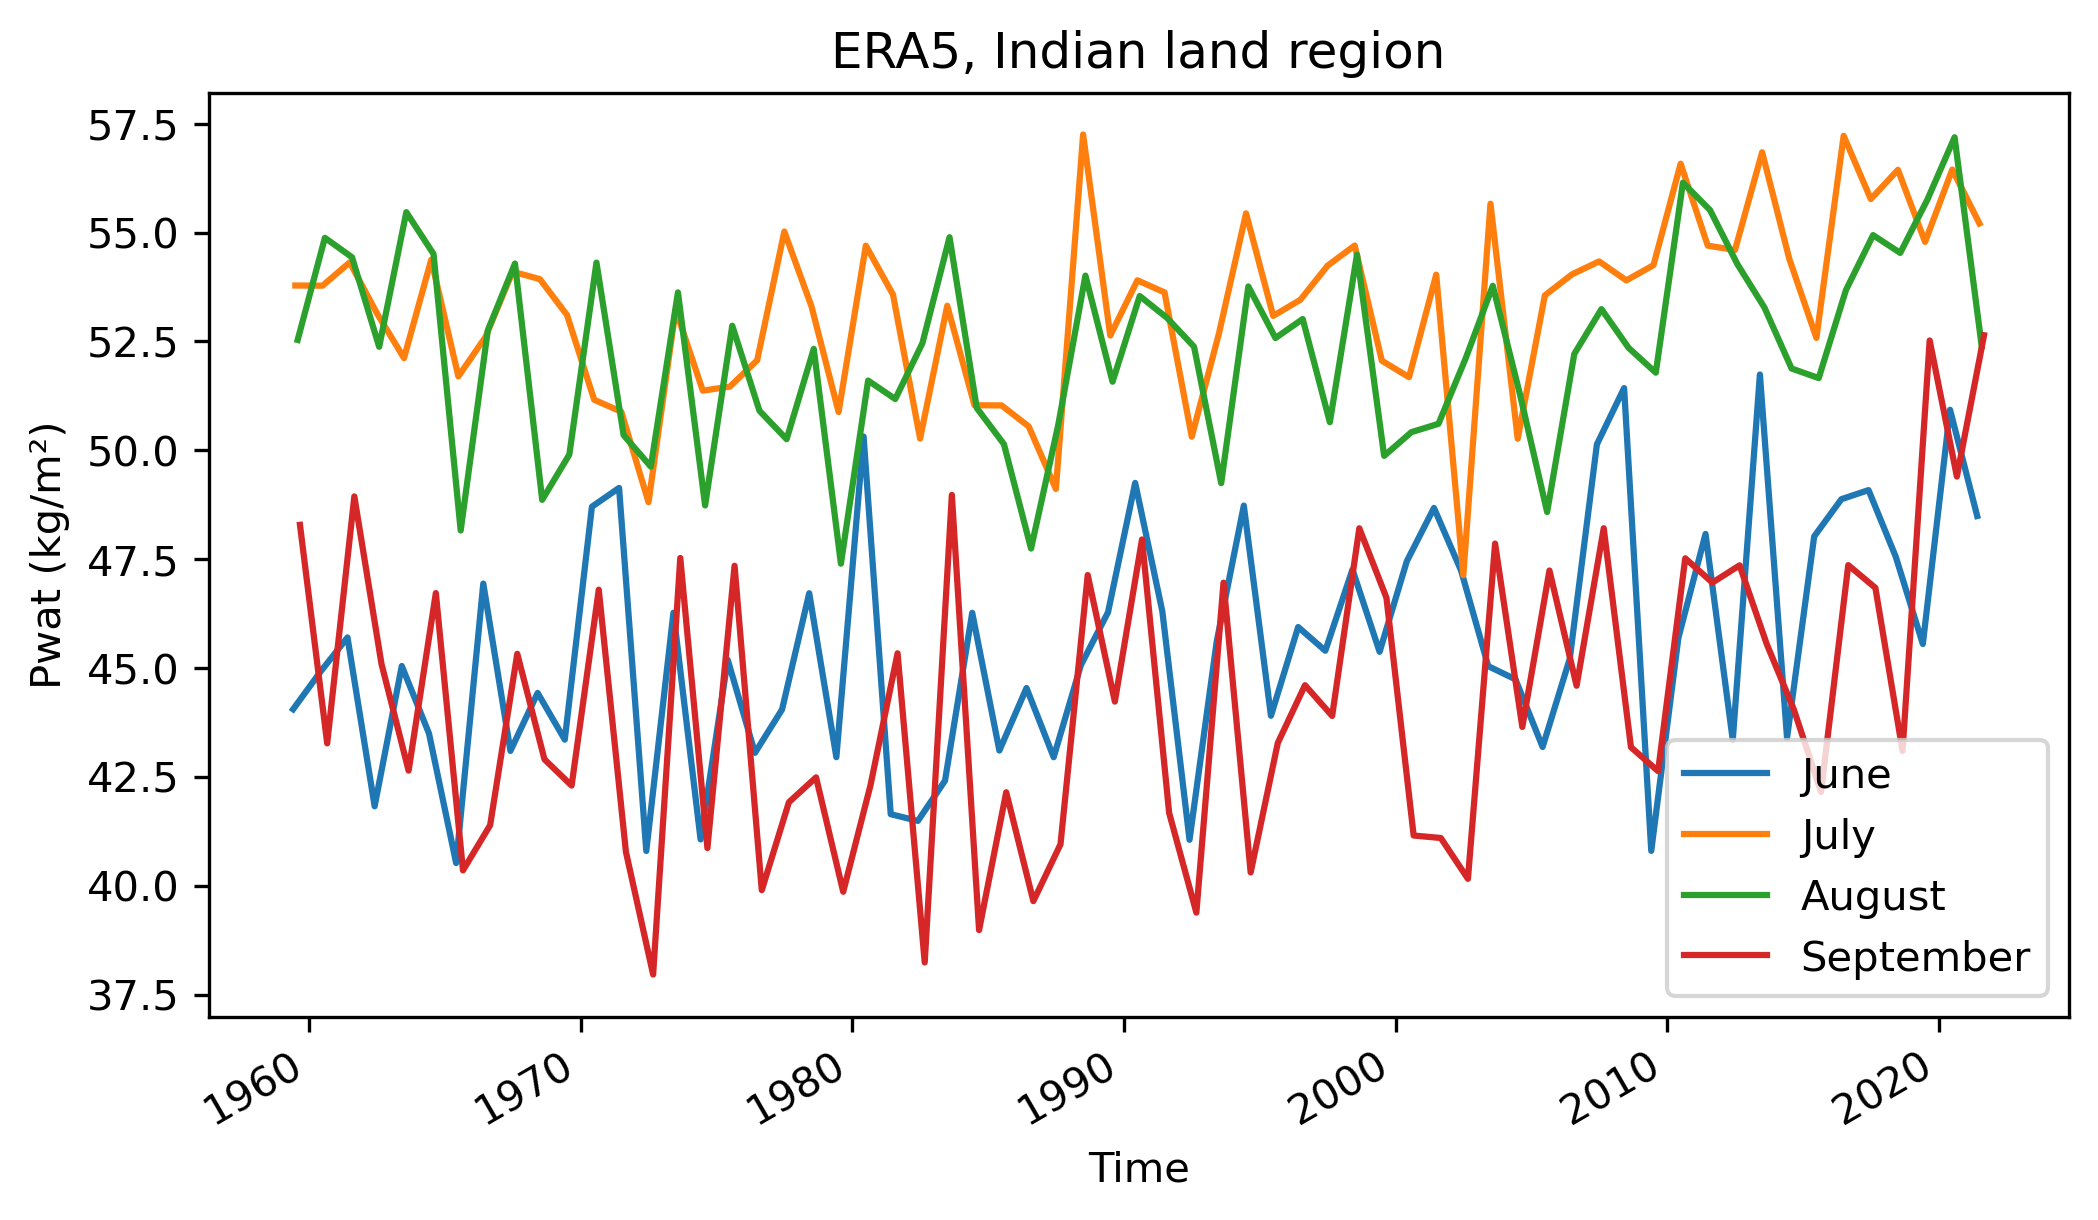

In [8]:
Pwat.sel(time=June).plot(label='June')
Pwat.sel(time=July).plot(label='July')
Pwat.sel(time=August).plot(label='August')
Pwat.sel(time=September).plot(label='September')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pwat (kg/m\u00b2)')
plt.title('ERA5, Indian land region')

Text(0.5, 1.0, 'ERA5, Indian land region')

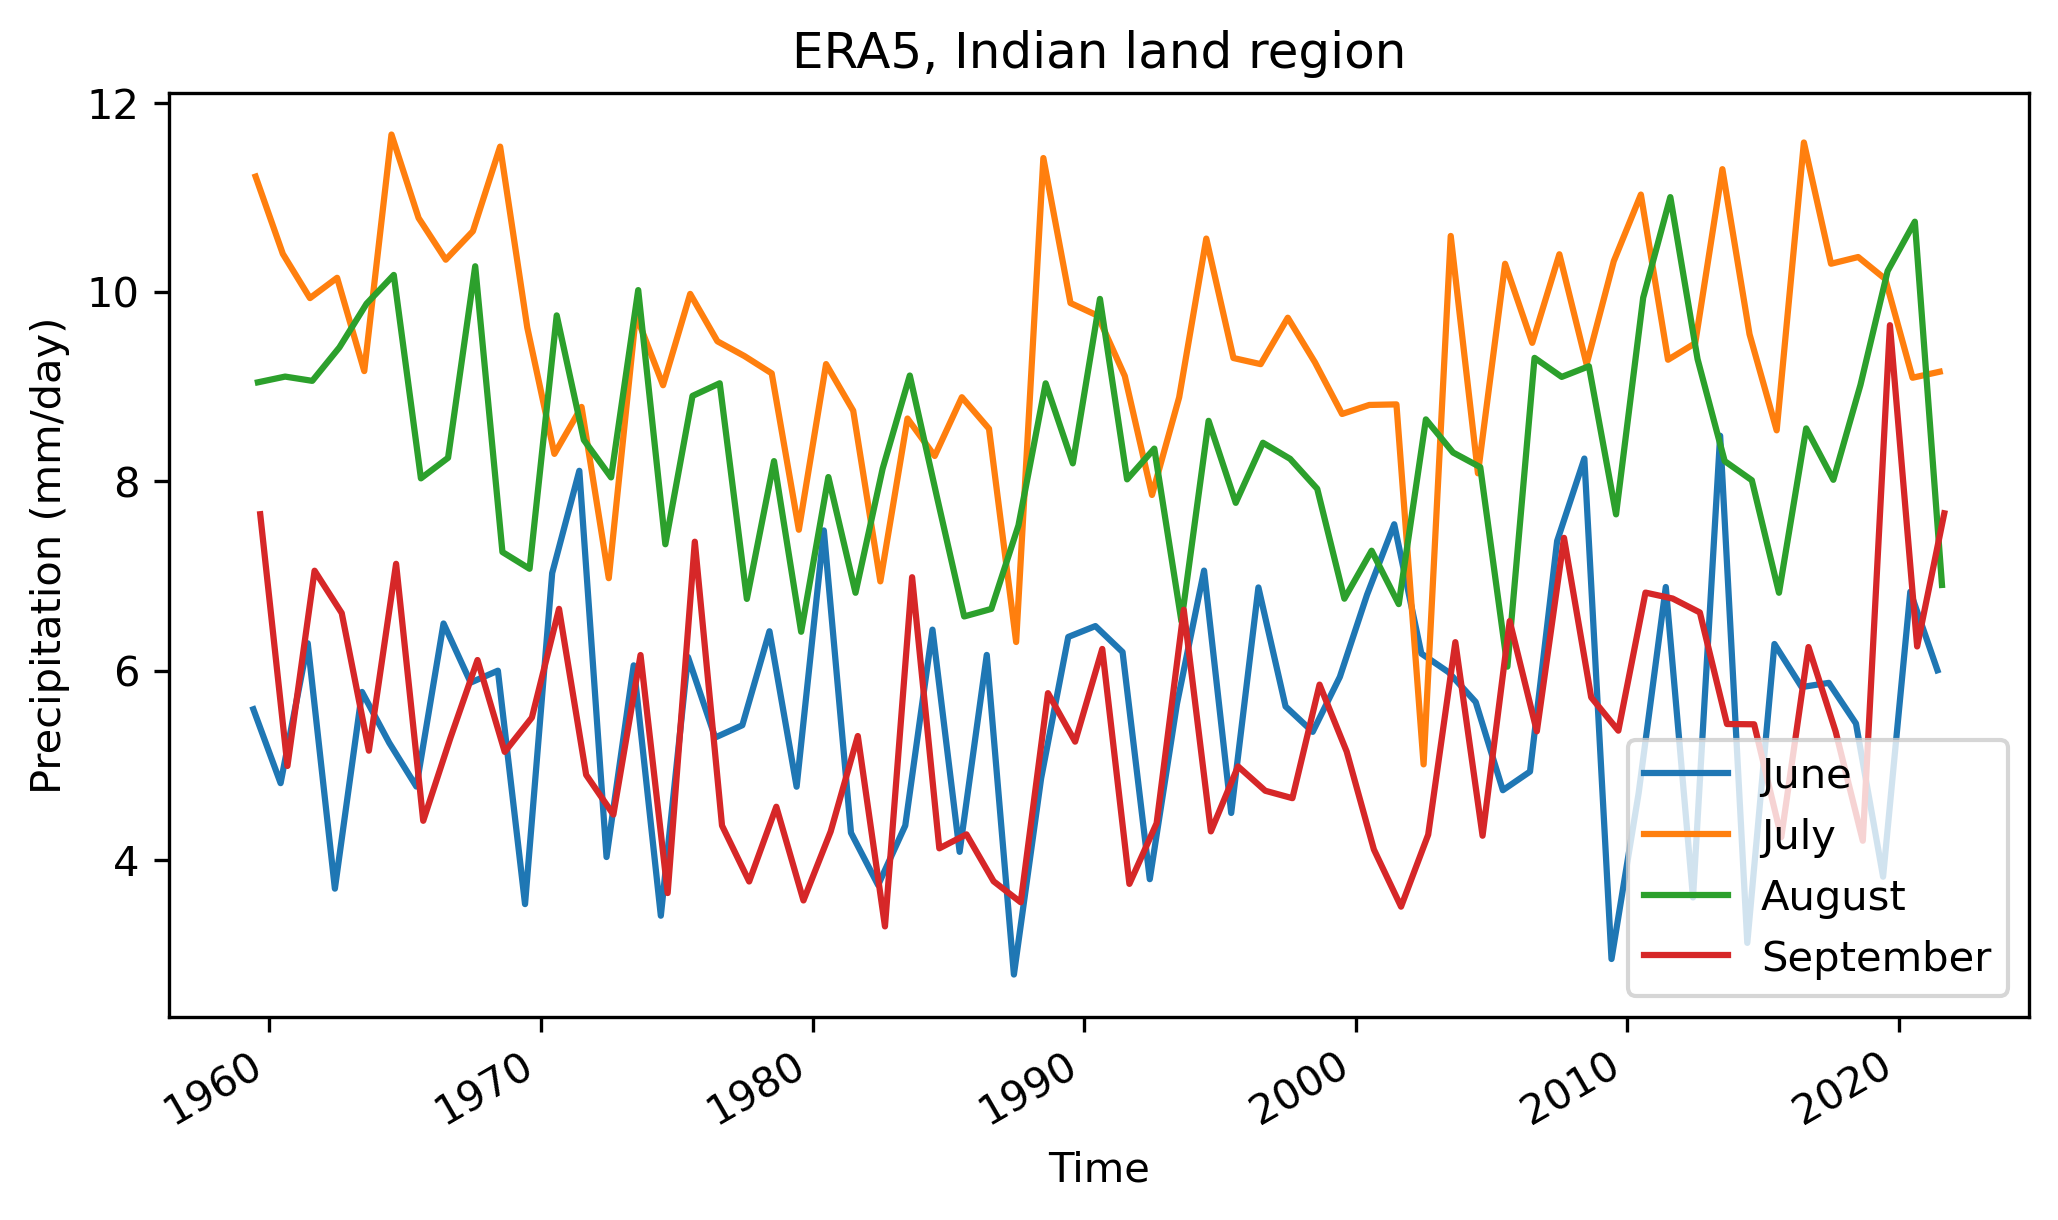

In [9]:
P.sel(time=June).plot(label='June')
P.sel(time=July).plot(label='July')
P.sel(time=August).plot(label='August')
P.sel(time=September).plot(label='September')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Precipitation (mm/day)')
plt.title('ERA5, Indian land region')

Text(0.5, 1.0, 'ERA5, Indian land region')

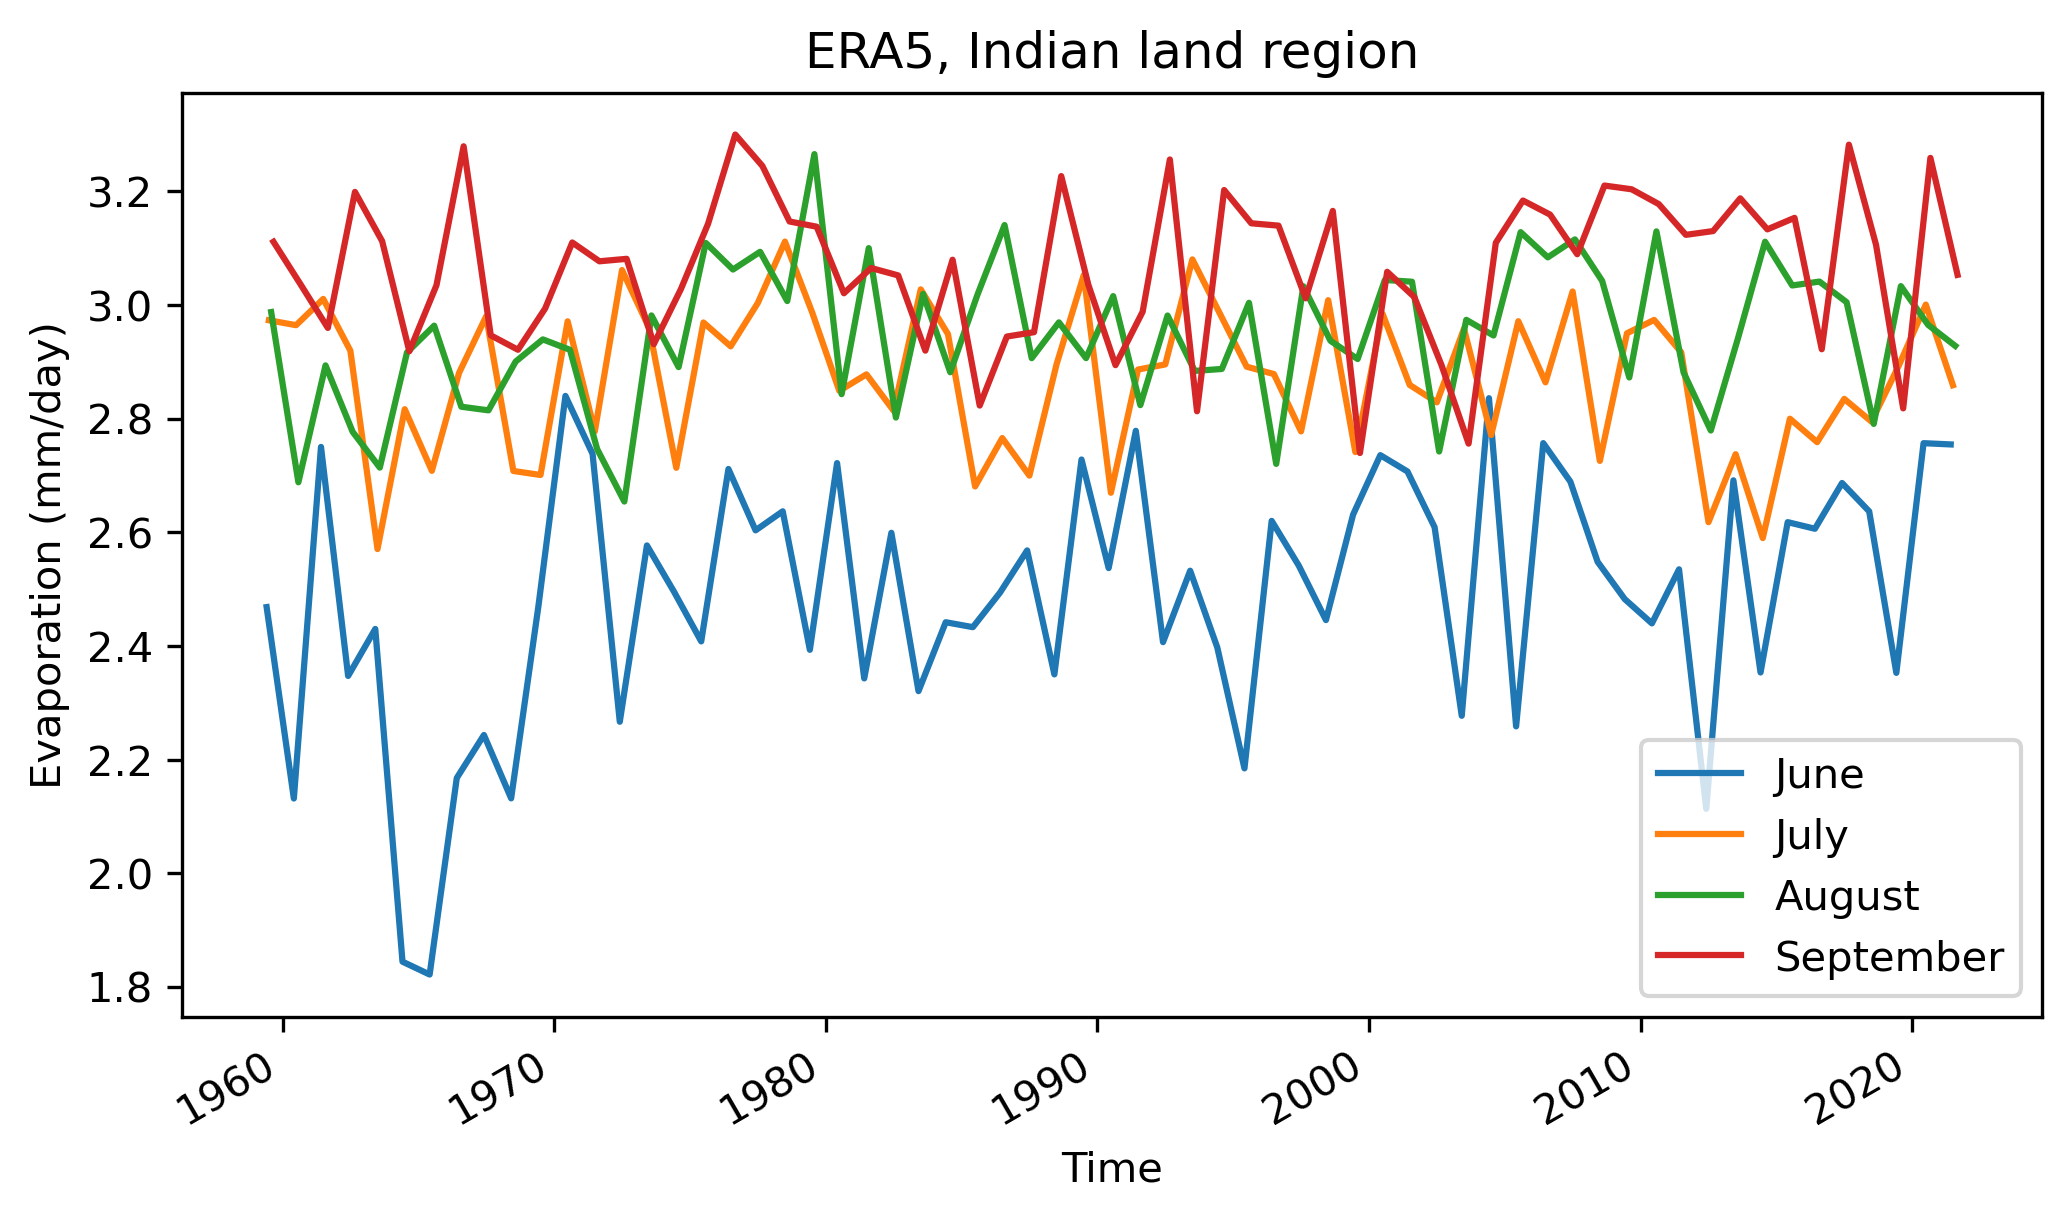

In [10]:
E.sel(time=June).plot(label='June')
E.sel(time=July).plot(label='July')
E.sel(time=August).plot(label='August')
E.sel(time=September).plot(label='September')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Evaporation (mm/day)')
plt.title('ERA5, Indian land region')

In [11]:
def pred(p,qnet,pwat):
    return pwat*((qnet/p)+1)

pred1 = pred(28.96*PE.sel(time=June).values, Qnet.sel(time=June).values, Pwat.sel(time=June).values)
pred2 = pred(28.96*PE.sel(time=July).values, Qnet.sel(time=July).values, Pwat.sel(time=July).values)
pred3 = pred(28.96*PE.sel(time=August).values, Qnet.sel(time=August).values, Pwat.sel(time=August).values)
pred4 = pred(28.96*PE.sel(time=September).values, Qnet.sel(time=September).values, Pwat.sel(time=September).values)

In [12]:
X = np.arange(1959, 2022, 1)

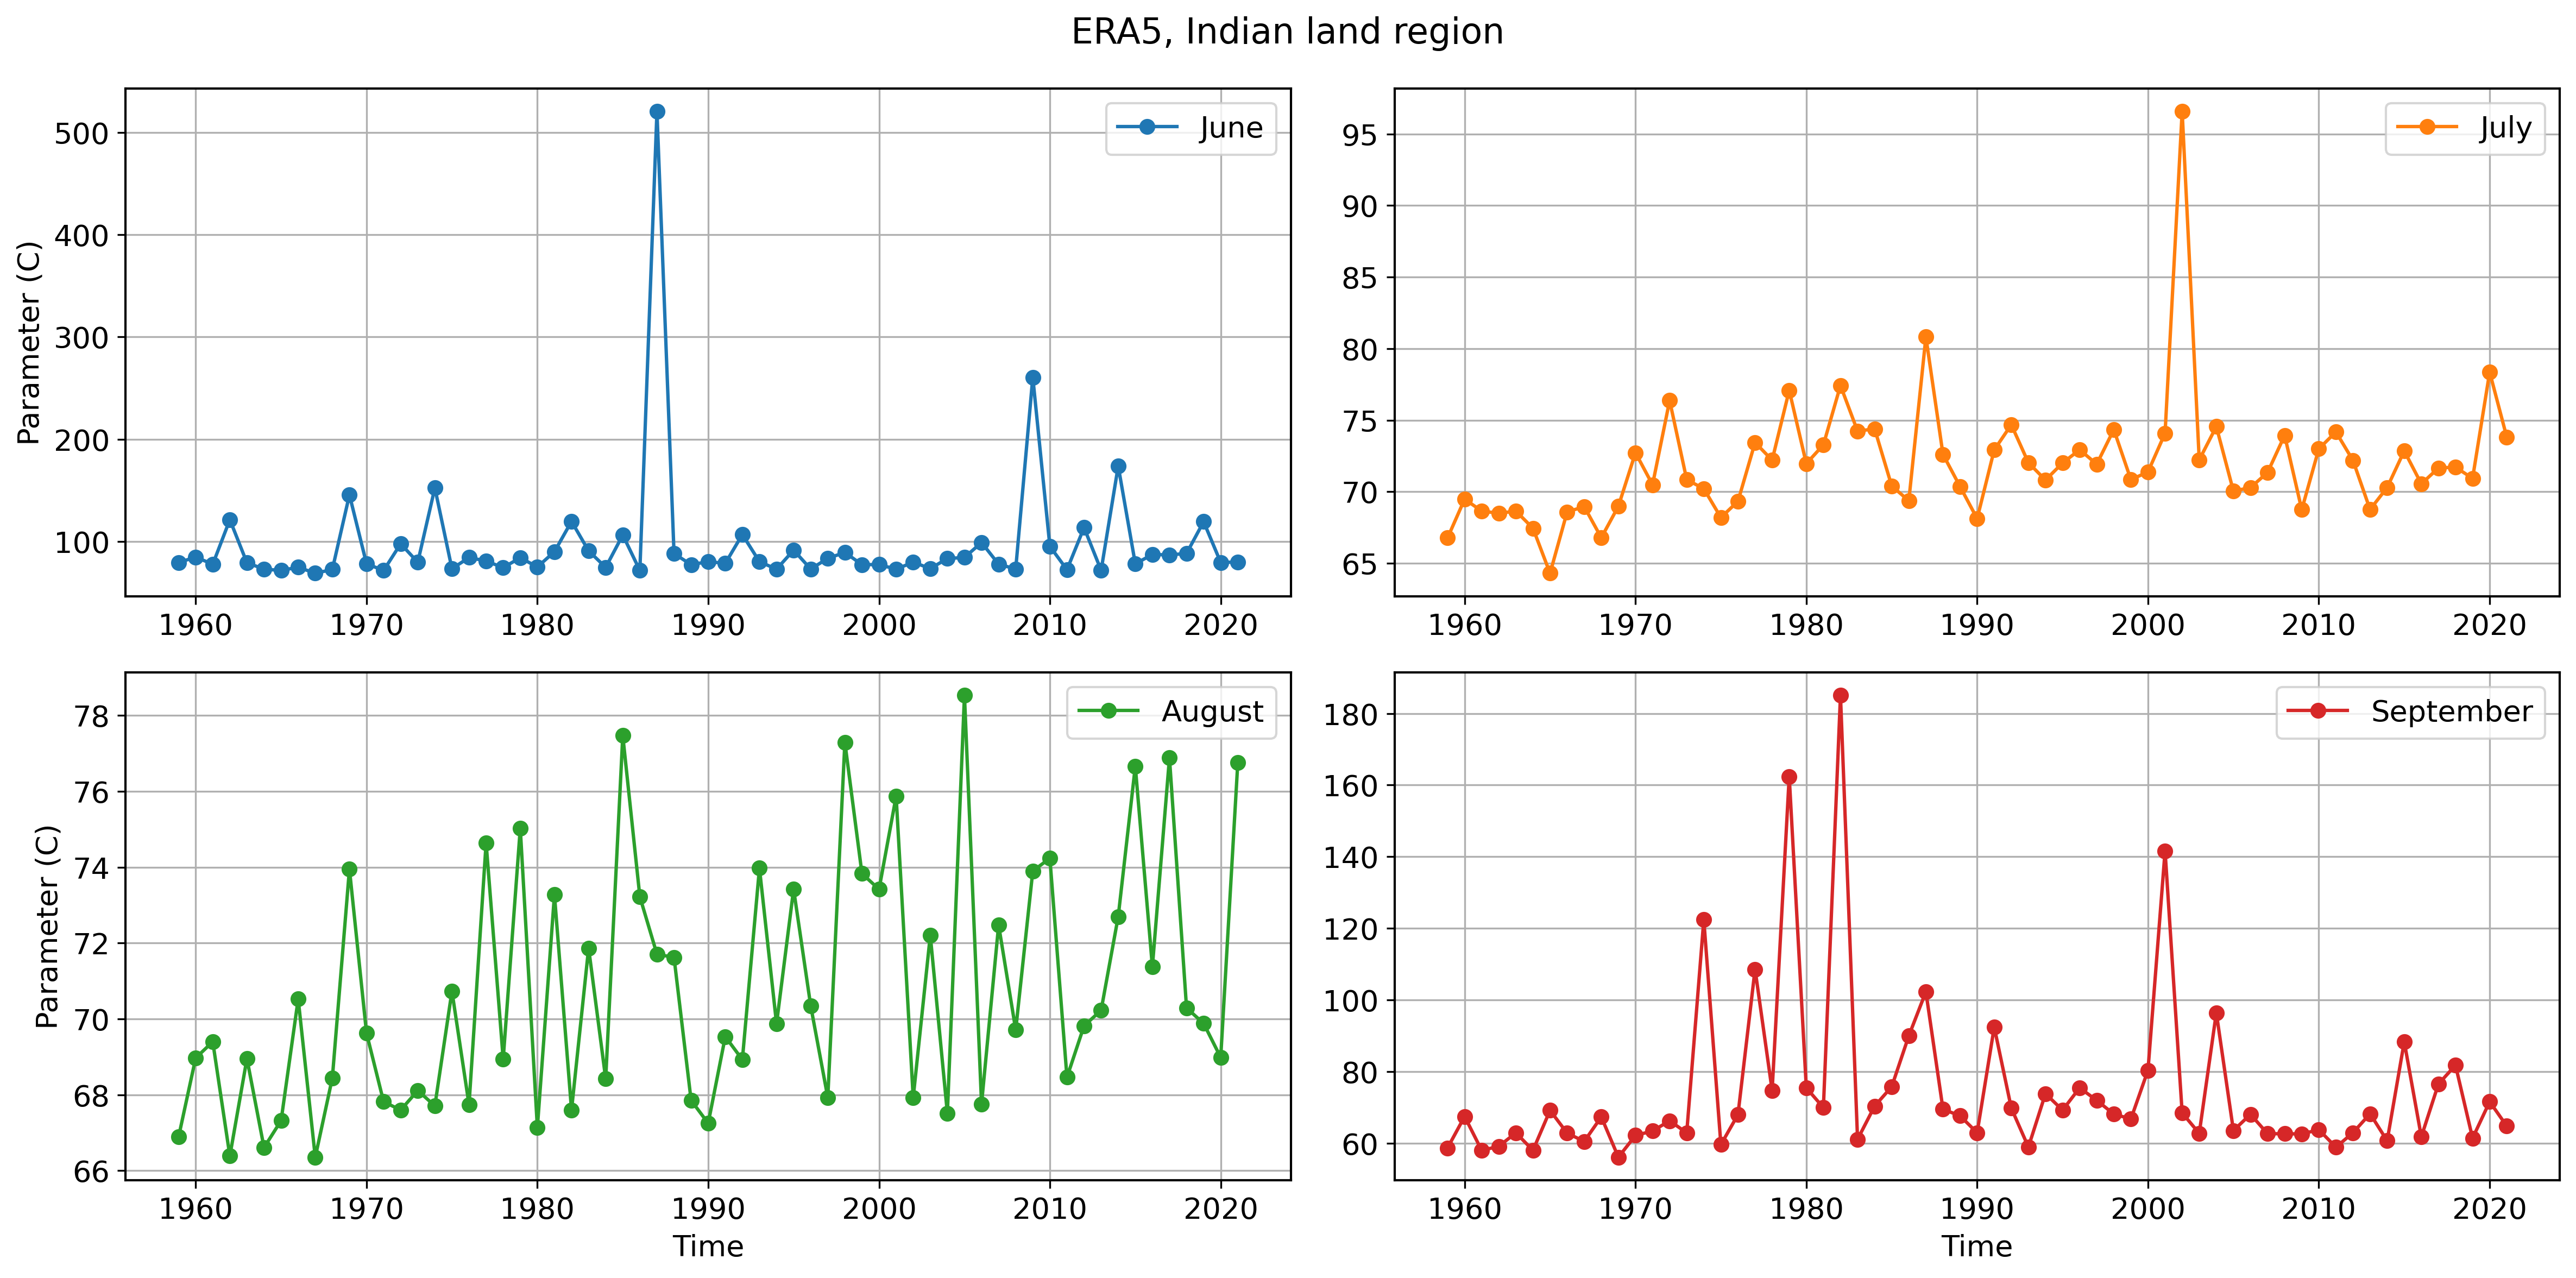

In [13]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 13})
mpl.rcParams['axes.linewidth'] = 1
plt.subplot(2,2,1)
plt.plot(X, pred1, label='June', marker='o')
plt.ylabel('Parameter (C)')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(X, pred2, label='July', c='tab:orange', marker='o')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(X, pred3, label='August', c='tab:green', marker='o')
plt.xlabel('Time')
plt.ylabel('Parameter (C)')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(X, pred4, label='September', c= u'#d62728', marker='o')
plt.legend()
plt.xlabel('Time')
plt.grid()
plt.suptitle('ERA5, Indian land region')

plt.tight_layout()

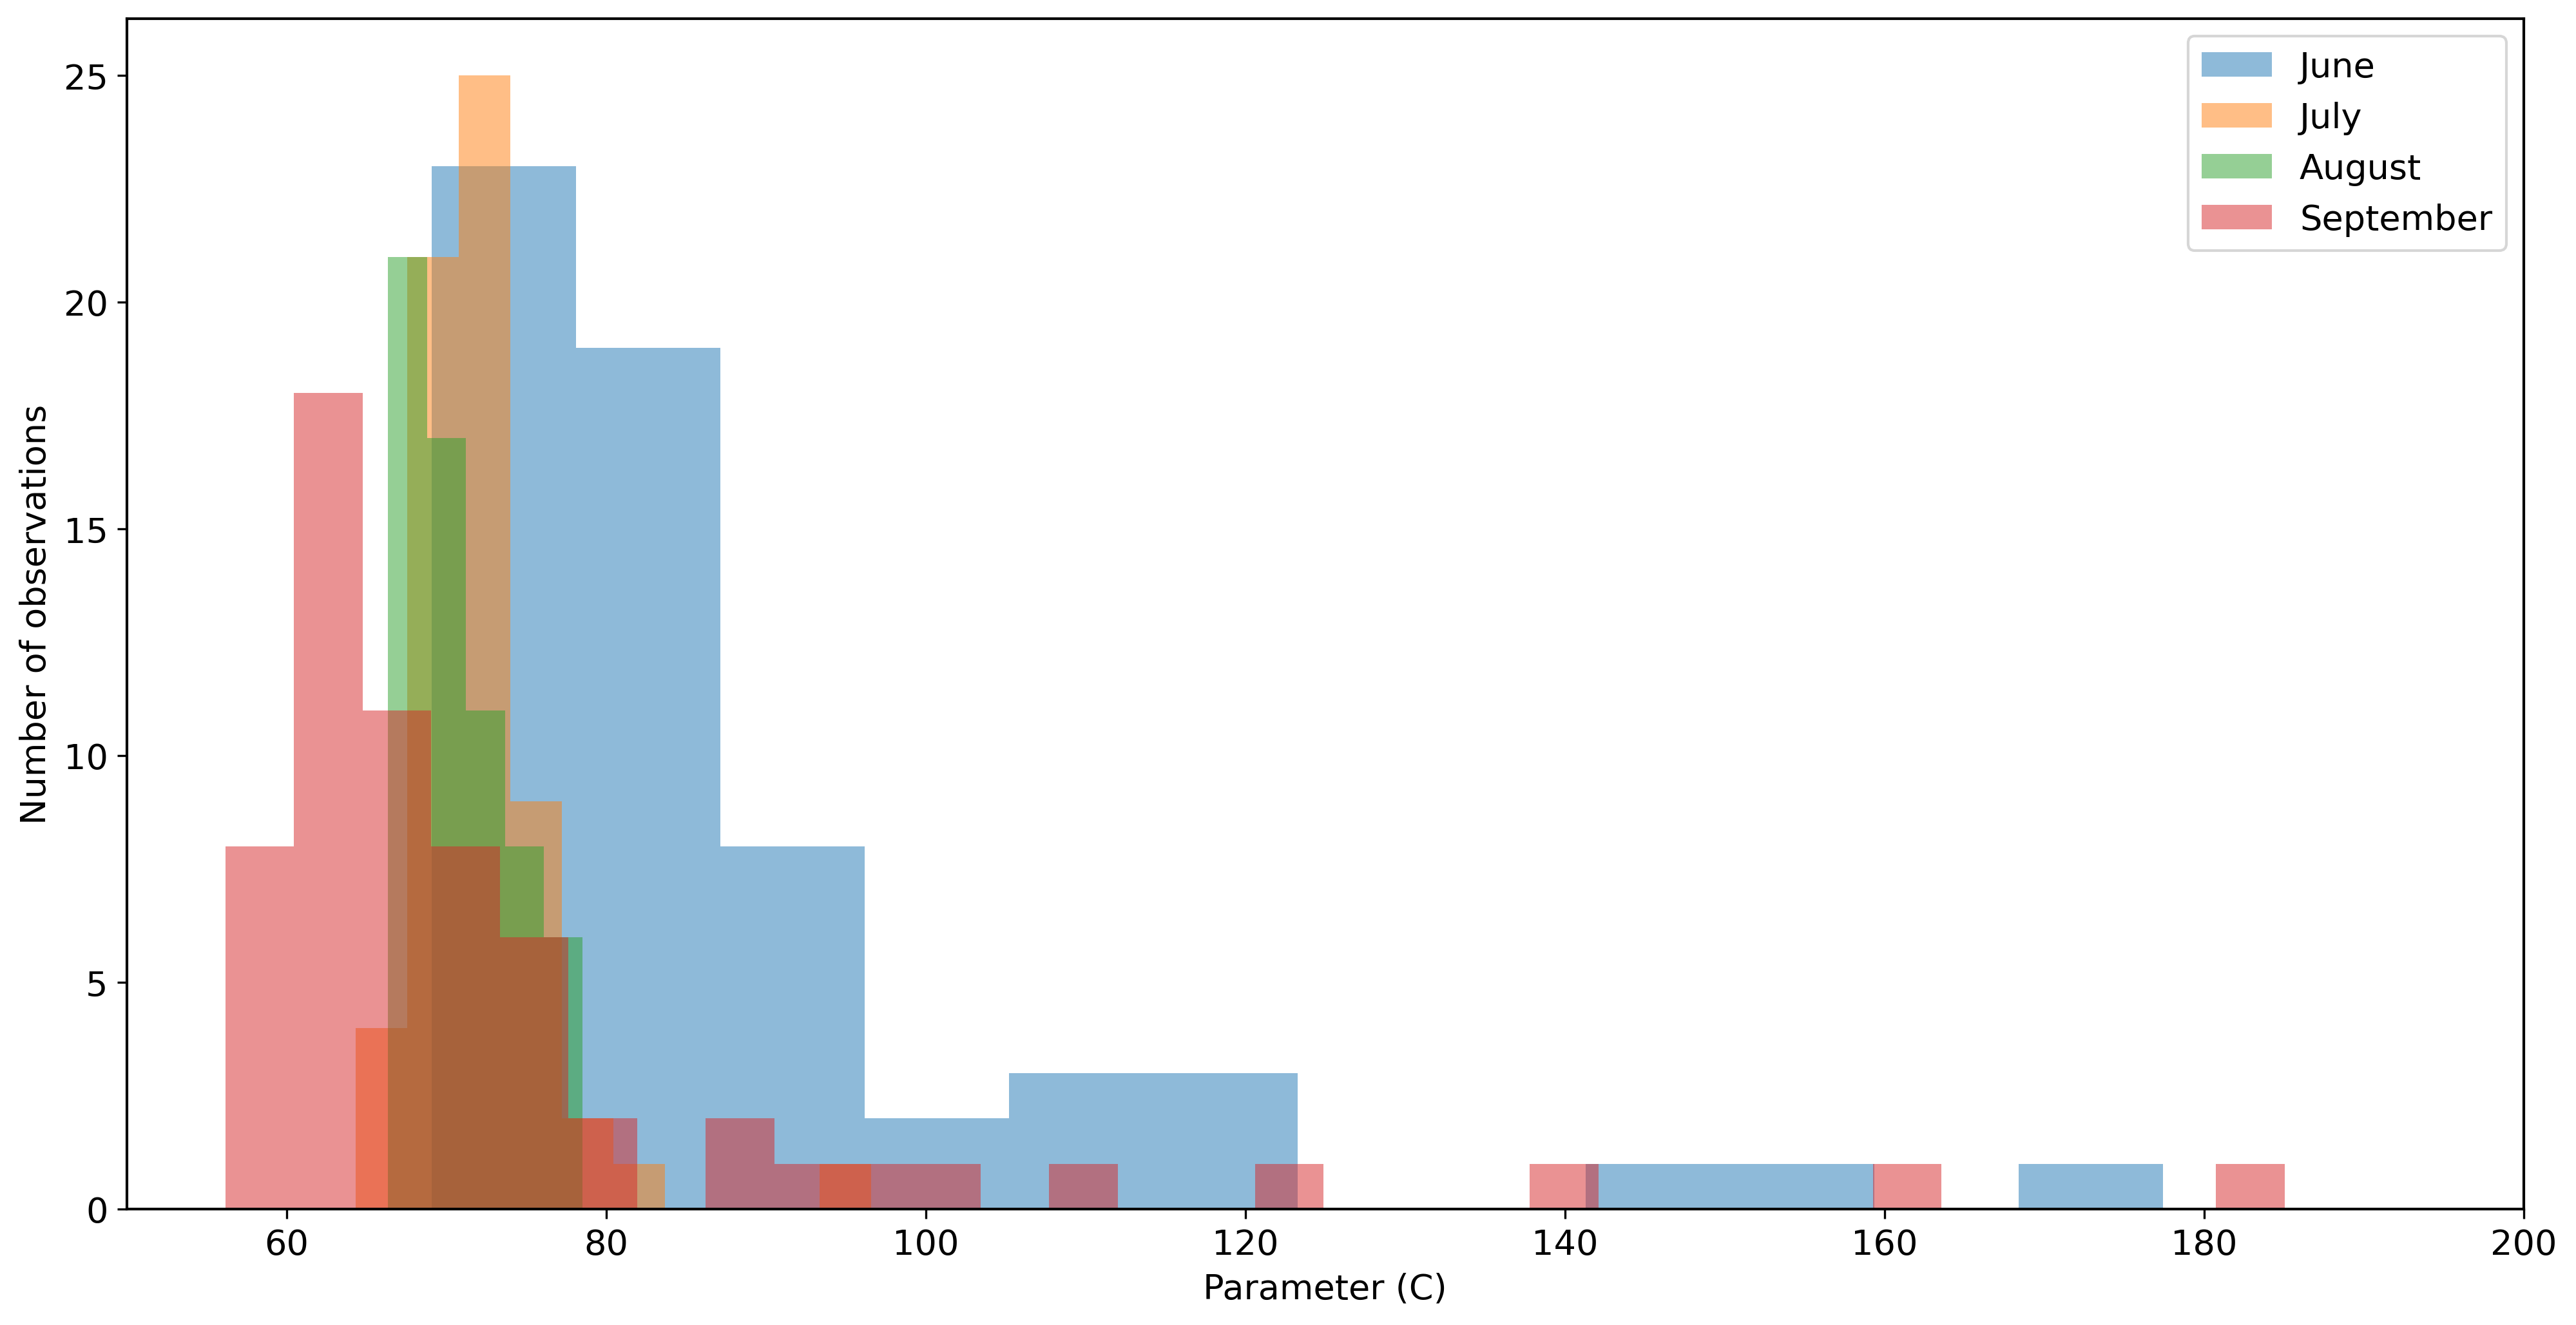

In [43]:
plt.hist(pred1, bins=50, alpha =0.5, label='June')
plt.hist(pred2, bins=10, alpha =0.5, label='July')
plt.hist(pred3, bins=5, alpha =0.5, label='August')
plt.hist(pred4, bins=30, alpha =0.5, label='September')
plt.xlabel('Parameter (C)')
plt.ylabel('Number of observations')
plt.xlim(50, 200)
plt.legend()
plt.show()

# Lapse rates, scale heights for individual months

In [47]:
g = 9.80616
Cp = 1004.64
Lv = 2.501e6
R = 287.05

In [48]:
c = '/media/rakshith/Seagate Expansion Drive/mraks/MSE India.nc'
ds3 = xr.open_dataset(c)

lon_grid1, lat_grid1 = np.meshgrid(ds3.longitude, ds3.latitude)
mask1 = globe.is_land(lat_grid1, lon_grid1)

In [49]:
jjas = ds3.time.dt.month.isin(9) #JJAS
clim = ds3.sel(time=jjas)

#clim = clim.groupby('time.year').mean('time')

#clim = ds3 #for all months
ds4 = clim.sel(level=slice(100,1000)).where(mask1>0).mean(dim=['latitude', 'longitude']).squeeze()
#selecting only till level 100mb

In [51]:
q = ds4.q
q0 = q.sel(level=1000)
divq = np.divide(q,q0)

p=100*ds4.level
p0=100000
divp = np.divide(p,p0)

T = ds4.t
T0 = T.sel(level=1000)

z=ds4.z/g

In [52]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
gammalist=[]
lambdalist=[]
for k in ds4.time:
    x1, y1 = np.log(divq.sel(time=k)).values.reshape(-1, 1), np.log(divp).values.reshape(-1, 1)
    regr.fit(x1, y1)
    y_pred1 = regr.predict(x1)
    lambda1 = regr.coef_[0][0]
    lambdalist.append(lambda1)
    
    x2, y2 = z.sel(time=k).values.reshape(-1, 1), T.sel(time=k).values.reshape(-1, 1)
    regr.fit(x2, y2)
    y_pred2 = regr.predict(x2)
    gamma1 = regr.coef_[0][0]
    gammalist.append(gamma1) 

In [53]:
gammalist = abs(np.array(gammalist))
lambdalist = np.divide(1,lambdalist)

In [54]:
X = np.arange(1959, 2022, 1)

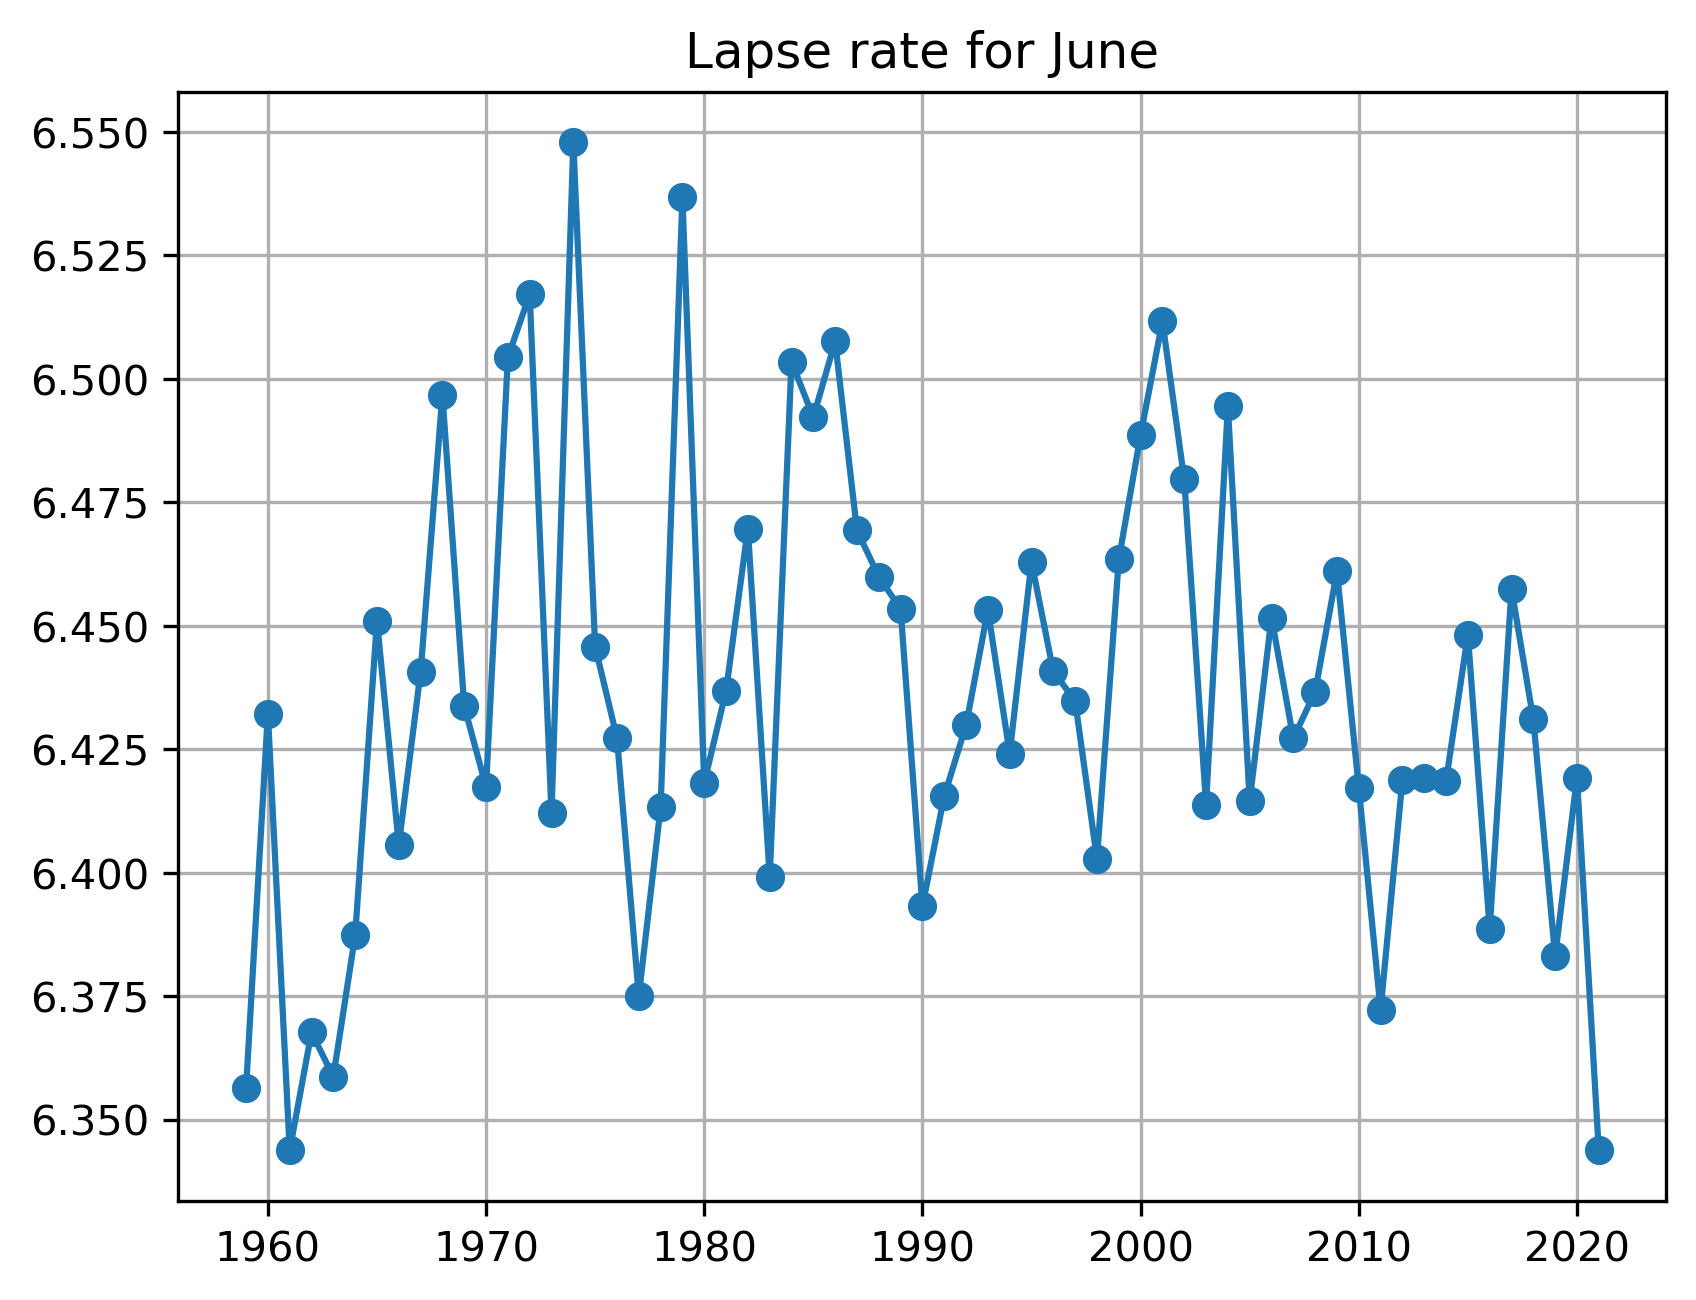

In [55]:
plt.plot(X, 1000*gammalist, marker='o')
plt.title('Lapse rate for June')
plt.grid()

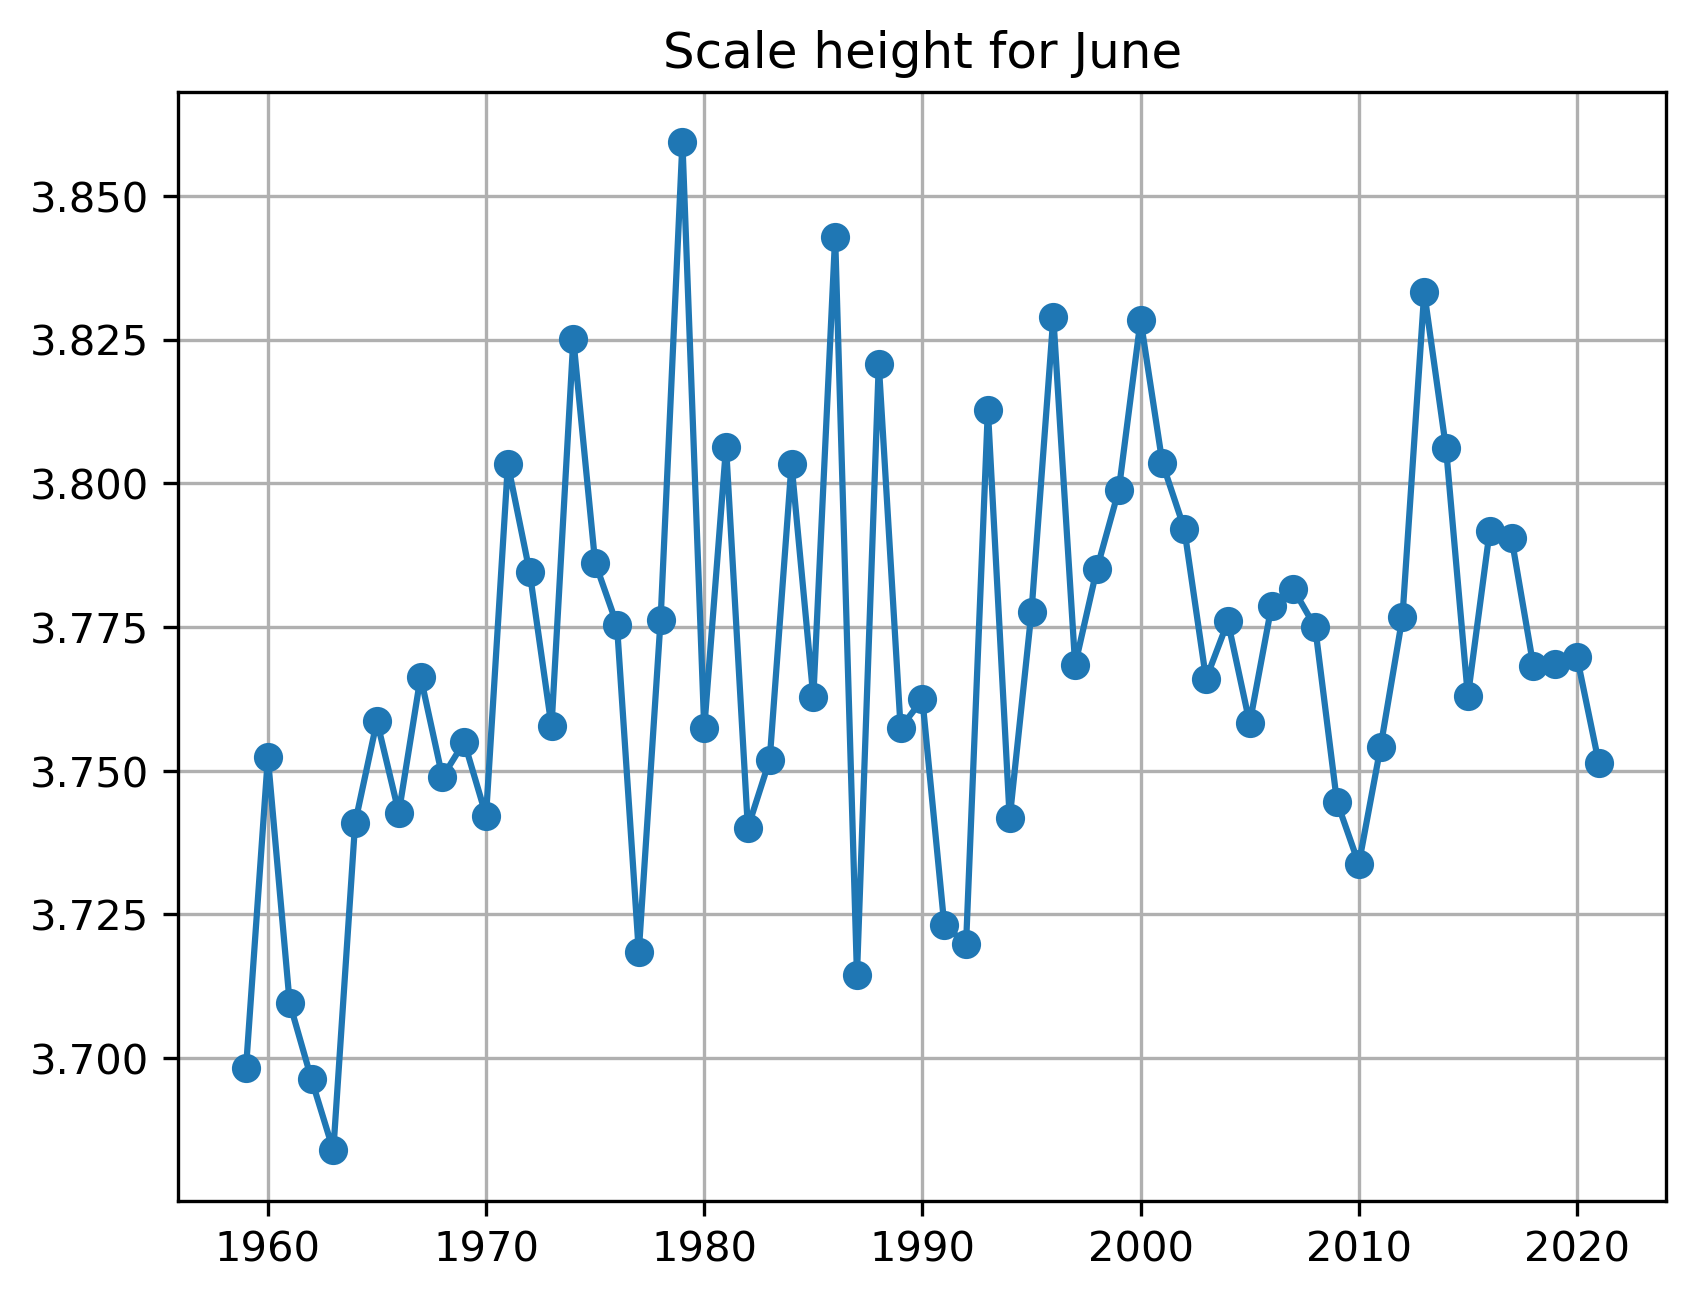

In [56]:
plt.plot(X, lambdalist, marker='o')
plt.title('Scale height for June')
plt.grid()

In [57]:
Pwatint = Pwat.sel(time=July)

In [58]:
l=lambdalist
a=g/(np.multiply(Cp, gammalist))
b=np.multiply(R, gammalist)/g

p0=100000
num = p0*(a-1)*b*(np.array(l)+2)*Cp*T0
den = Lv*g*np.array(l)*(b+1)*(b+2)
#del1 = num/(den*Pwatint)

const = num/den

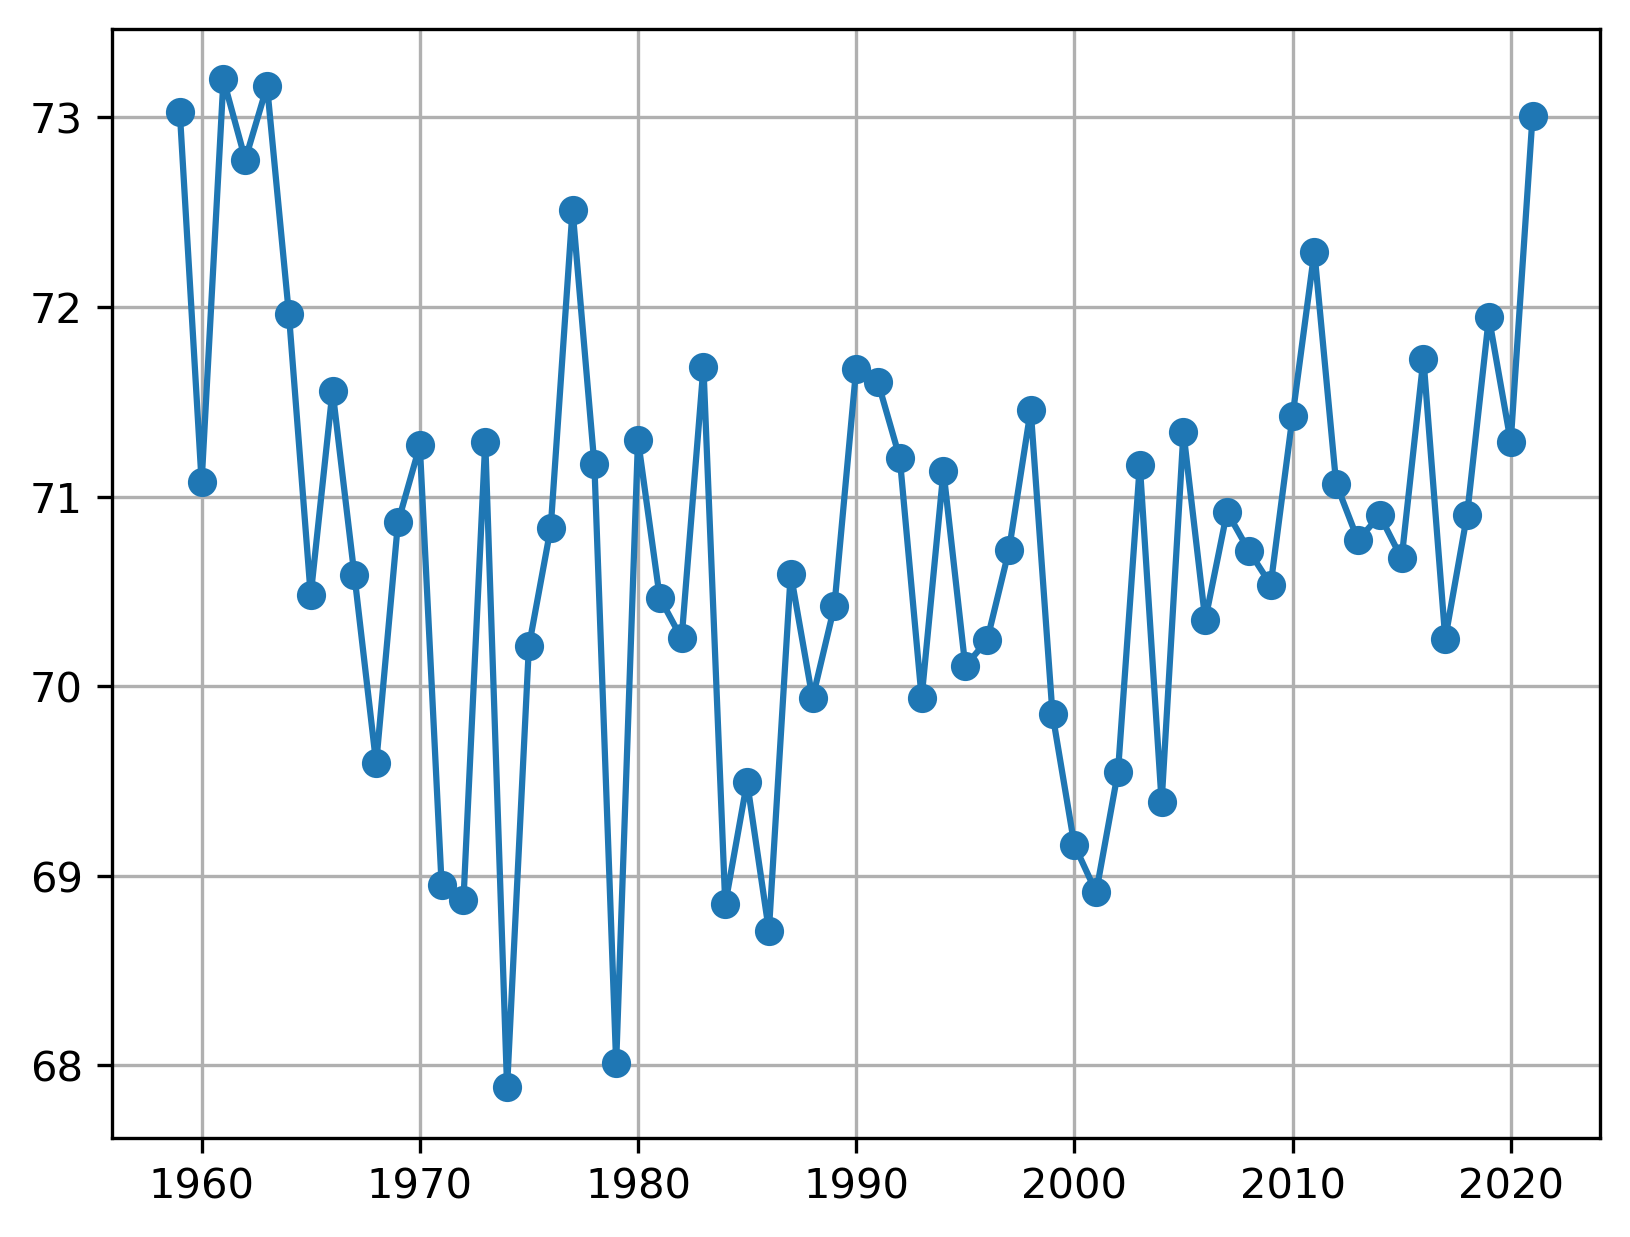

In [59]:
plt.plot(X, const, marker='o')
plt.grid()

In [60]:
constsep = np.array([73.02820108, 71.07560384, 73.19904622, 72.77671751, 73.16428217,
       71.96241605, 70.47967137, 71.55771951, 70.58763635, 69.5925857 ,
       70.86334335, 71.26957426, 68.9531652 , 68.87064776, 71.28950488,
       67.88433586, 70.20969979, 70.83494921, 72.51212072, 71.17136134,
       68.01106393, 71.29868646, 70.46569733, 70.25144921, 71.68240613,
       68.85038964, 69.49535945, 68.71106387, 70.5933594 , 69.93541296,
       70.4207758 , 71.67255582, 71.60218827, 71.20163278, 69.93895853,
       71.13395282, 70.10625412, 70.24127158, 70.71546871, 71.45678551,
       69.85088456, 69.1632604 , 68.91302282, 69.54831761, 71.16763654,
       69.38900153, 71.3383025 , 70.34898891, 70.91928542, 70.71370771,
       70.53524424, 71.42223129, 72.29103258, 71.06789458, 70.77027335,
       70.90042957, 70.67320412, 71.72571762, 70.25117153, 70.90259194,
       71.94460466, 71.28821925, 73.00392828])

In [61]:
constjune = np.array([69.66186707, 69.29690458, 71.29131711, 70.08334918, 71.45939949,
       68.13497512, 67.86717222, 69.92317023, 69.30182376, 68.25278909,
       68.62439605, 71.31191636, 71.99229878, 65.85249647, 70.83651187,
       68.75892153, 70.54091686, 69.74694602, 70.43932521, 71.47355232,
       67.74378411, 71.50991822, 69.03011199, 69.31447712, 68.39889248,
       70.87017113, 69.40419945, 68.91046825, 68.50923825, 70.12876197,
       69.73092343, 71.82763376, 70.83065253, 67.67700251, 69.21211776,
       70.65034794, 68.80043865, 69.4409181 , 68.51859423, 71.31179632,
       70.07643047, 70.32889815, 71.33064948, 69.64335229, 68.86042575,
       70.25102976, 68.40354802, 69.97314849, 70.34221084, 71.75077781,
       66.91001594, 70.03029117, 71.99823116, 69.16779184, 72.76108521,
       69.7270833 , 71.9476814 , 70.67170043, 70.92343281, 70.83664914,
       69.73145006, 73.05622617, 72.6217455 ])

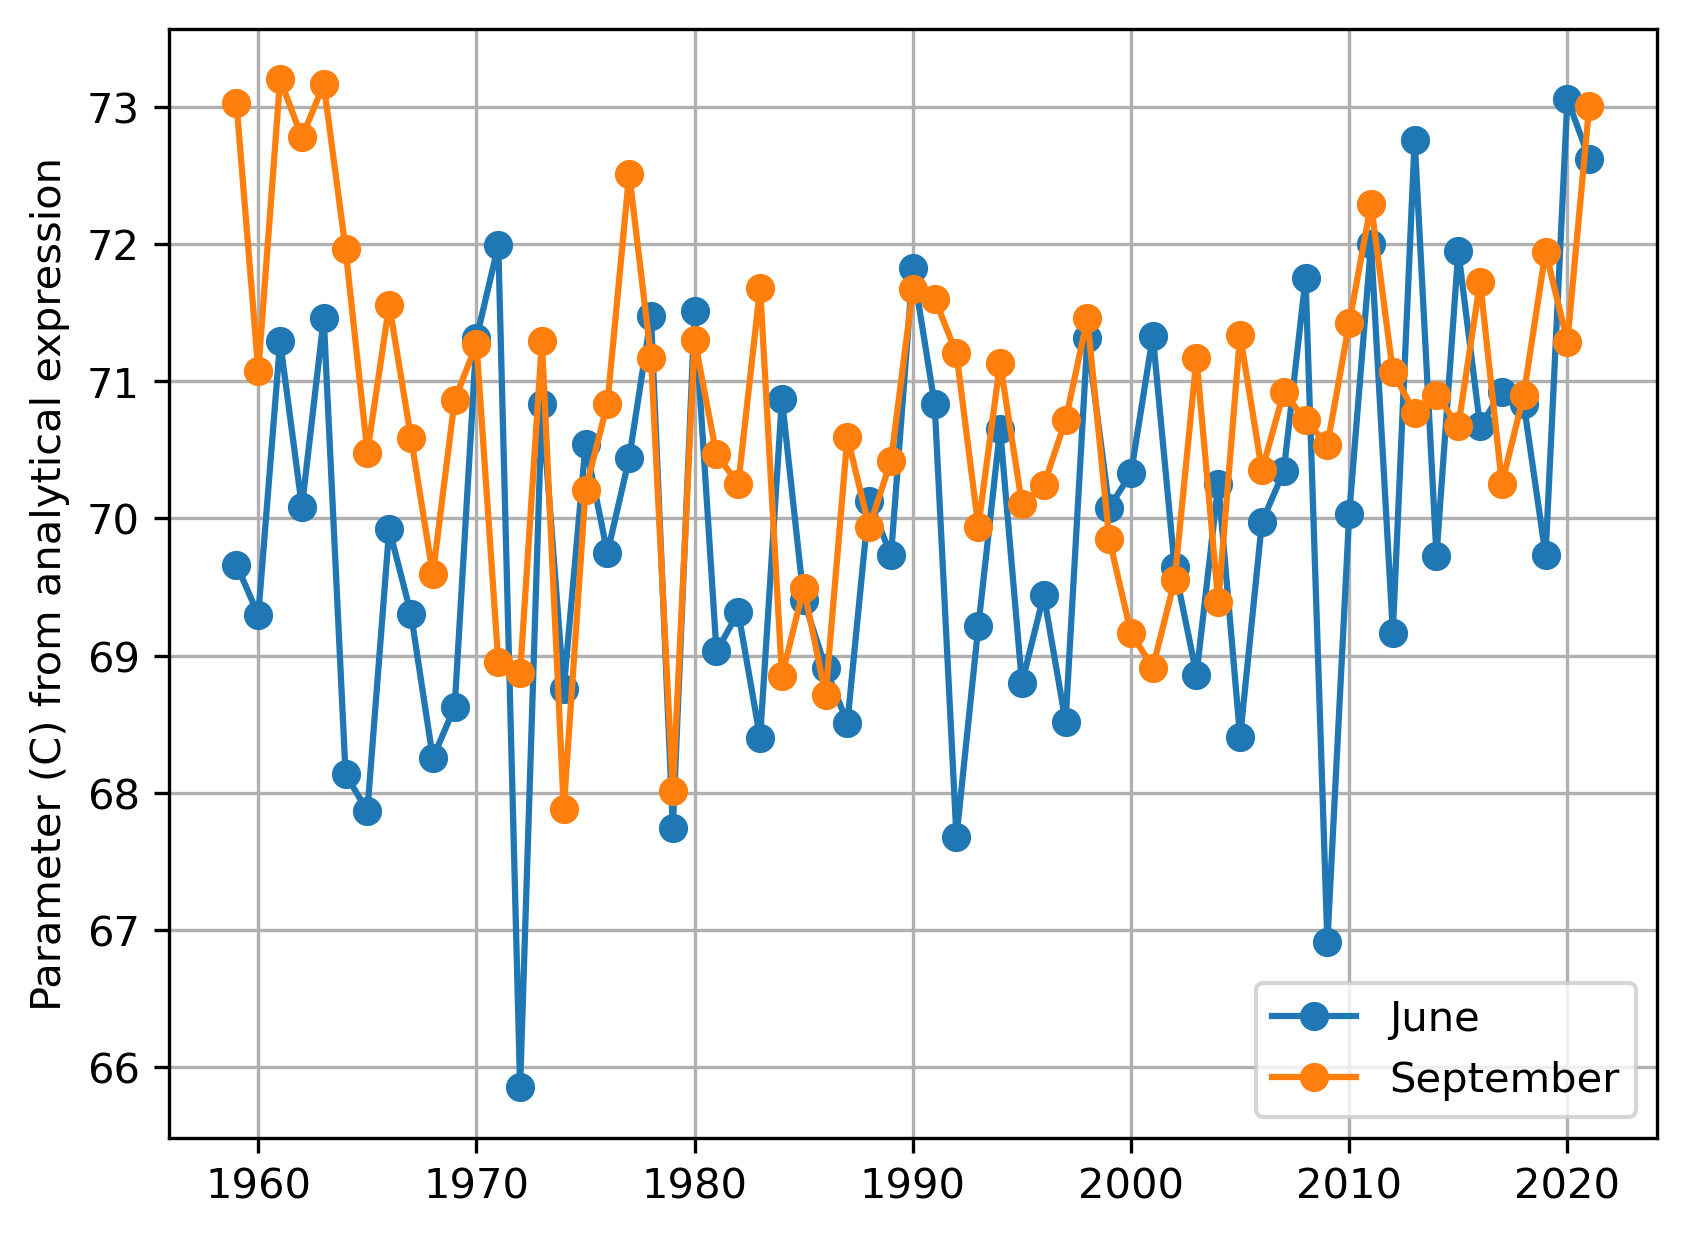

In [62]:
plt.plot(X, constjune, marker='o', label='June')
plt.plot(X, constsep, marker='o', label='September')
plt.legend()
plt.ylabel('Parameter (C) from analytical expression')
plt.grid()

# udm/dx and vdm/dy comparison for June and September

In [71]:
d = '/media/rakshith/Seagate Expansion Drive/mraks/ERA TGMS all variables India.nc'
ds7 = xr.open_dataset(d)
jjas = ds7.time.dt.month.isin(range(6, 10)) #JJAS
#jjas = ds7.time.dt.month.isin(6)
clim1 = ds7.sel(time=jjas)

lon_grid1, lat_grid1 = np.meshgrid(ds7.longitude, ds7.latitude)
mask1 = globe.is_land(lat_grid1, lon_grid1)

In [72]:
import warnings;
warnings.filterwarnings('ignore');

In [73]:
spind = '/media/rakshith/Seagate Expansion Drive/mraks/ERA surface pressure India.nc'
ds10 = xr.open_dataset(spind)
jjas = ds10.time.dt.month.isin(range(6, 10)) #JJAS
#jjas = ds10.time.dt.month.isin(6)
clim2 = ds10.sel(time=jjas)

In [75]:
June = clim1.time.dt.month.isin(6)
July = clim1.time.dt.month.isin(7)
August = clim1.time.dt.month.isin(8)
September = clim1.time.dt.month.isin(9)

In [83]:
import metpy.calc as mpcalc

In [93]:
#MSE advection terms
x=ds7.level
xs= np.arange(1, 1001, 1)
jadvind=[]
for j in clim1.sel(time=June).time:
    ds8 = clim1.sel(time=j)
    ps1 = clim2.sel(time=j)
    m = Cp*ds8.t + Lv*ds8.q + ds8.z
    jadv = mpcalc.advection(m, u=ds8.u, v=ds8.v, w=ds8.w)
    inter = jadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    jadvind.append(-100*integral.where(mask1>0).mean(dim=['latitude', 'longitude']))

TypeError: unsupported operand type(s) for *: 'int' and 'method'

In [89]:
sadvind=[]
for j in clim1.sel(time=September).time:
    ds8 = clim1.sel(time=j)
    ps1 = clim2.sel(time=j)
    m = Cp*ds8.t + Lv*ds8.q + ds8.z
    sadv = mpcalc.advection(m, u=ds8.u, v=ds8.v, w=ds8.w)
    inter = sadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    sadvind.append(-100*integral.where(mask1>0).mean(dim=['latitude', 'longitude']).values)

In [91]:
X = np.arange(1959, 2022, 1)

In [98]:
#plt.plot(X, np.array(jadvind), label='June')
plt.plot(X, np.array(sadvind), label='September')
plt.legend()

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.